In [0]:
!git clone -l -s https://github.com/vartult/Traffic_Sign.git

Cloning into 'Traffic_Sign'...
remote: Enumerating objects: 7338, done.
remote: Total 7338 (delta 0), reused 0 (delta 0), pack-reused 7338
Receiving objects: 100% (7338/7338), 245.48 MiB | 7.08 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (7221/7221), done.


In [0]:
import numpy as np
import tensorflow as tf

import os
import skimage.data
import skimage.transform

from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.models import Sequential

import matplotlib
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
def load_data(data_dir):

    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]

    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) if f.endswith(".ppm")]
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    return images, labels
ROOT_PATH = "/content/Traffic_Sign"
train_data_dir = os.path.join(ROOT_PATH, "Training")
test_data_dir = os.path.join(ROOT_PATH, "Testing")

images, labels = load_data(train_data_dir)




In [0]:
print(labels[10])

53


In [0]:
images32 = [skimage.transform.resize(image, (32, 32), mode='constant') for image in images]
# Prepare the training dataset
labels_a = np.array(labels)
images_a = np.array(images32)
print("labels: ", labels_a.shape, "\nimages: ", images_a.shape)

factor = 0.95
tr = int(len(labels)*factor)

X_dat = images_a
Y_dat = np.zeros((len(labels),62))
Y_dat[np.arange(len(labels)),labels] = 1
print("labels: ", Y_dat.shape, "\nimages: ", X_dat.shape)

X_train = X_dat
y_train = Y_dat

print(y_train.shape)

labels:  (4575,) 
images:  (4575, 32, 32, 3)
labels:  (4575, 62) 
images:  (4575, 32, 32, 3)
(4575, 62)


In [0]:
# Prepare the test dataset.
test_images, test_labels = load_data(test_data_dir)

# Transform the images, just like we did with the training set.
test_images32 = [skimage.transform.resize(image, (32, 32), mode='constant') for image in test_images]

test_labels = np.array(test_labels)
test_images32 = np.array(test_images32)
print("labels: ", test_labels.shape, "\nimages: ", test_images32.shape)

X_test = test_images32
y_test = np.zeros((len(test_labels),62))
y_test[np.arange(len(test_labels)),test_labels] = 1
print("labels: ", y_test.shape, "\nimages: ", X_test.shape)

labels:  (2520,) 
images:  (2520, 32, 32, 3)
labels:  (2520, 62) 
images:  (2520, 32, 32, 3)


In [0]:
def model(x, logits=False, training=False):

    with tf.variable_scope('conv0'):
        z = tf.layers.conv2d(x, filters=32, kernel_size=[3, 3], padding='same', activation=tf.nn.relu)
        z = tf.layers.max_pooling2d(z, pool_size=[2, 2], strides=2)

    with tf.variable_scope('conv1'):
        z = tf.layers.conv2d(z, filters=64, kernel_size=[3, 3], padding='same', activation=tf.nn.relu)
        z = tf.layers.max_pooling2d(z, pool_size=[2, 2], strides=2)

    with tf.variable_scope('flat'):
        shape = z.get_shape().as_list()
        z = tf.reshape(z, [-1, np.prod(shape[1:])])

    with tf.variable_scope('dense'):
        z = tf.layers.dense(z, units=128, activation=tf.nn.relu)
        z = tf.layers.dropout(z, rate=0.25)

    logits_ = tf.layers.dense(z, units=62, name='logits')
    y = tf.nn.softmax(logits_, name='ybar')

    if logits == True: #if logits is True
        return y, logits_
    return y 

In [0]:
def fgm(model, x, eps=0.01, epochs=1, sign=True, clip_min=0, clip_max=1):
    xadv = tf.identity(x)
    ybar = model(xadv) # returns 10x1 matrix, each number is between 0 and 1

    indices = tf.argmax(ybar, axis=1) #returns max index
    target = tf.one_hot(indices, 62, on_value=1.0, off_value=0.0)
    eps = tf.abs(eps)

    def _cond(xadv, i):
        return tf.less(i, epochs)

    def _body(xadv, i):
        ybar, logits = model(xadv, logits=True)
        loss = tf.nn.softmax_cross_entropy_with_logits(labels=target, logits=logits)
        dy_dx, = tf.gradients(loss, xadv)
        xadv = tf.stop_gradient(xadv + eps*tf.sign(dy_dx))
        xadv = tf.clip_by_value(xadv, clip_min, clip_max)
        return xadv, i+1

    xadv, _ = tf.while_loop(_cond, _body, (xadv, 0), back_prop=False, name='fast_gradient')
    return xadv

In [0]:
#tf.reset_default_graph() 

class Environment():
    pass

env = Environment()

with tf.variable_scope('model', reuse=False):
    env.x = tf.placeholder(tf.float32, (None, 32, 32, 3))
    env.y = tf.placeholder(tf.float32, (None, 62), name='y')

    env.ybar, logits = model(env.x, logits=True)

    with tf.variable_scope('acc'):
        count = tf.equal(tf.argmax(env.y, axis=1), tf.argmax(env.ybar, axis=1))
        env.acc = tf.reduce_mean(tf.cast(count, tf.float32), name='acc')

    with tf.variable_scope('loss'):
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=env.y, logits=logits)
        env.loss = tf.reduce_mean(cross_entropy, name='loss')

    with tf.variable_scope('train_op'):
        optimizer = tf.train.AdamOptimizer()
        env.train_op = optimizer.minimize(env.loss)

with tf.variable_scope('model', reuse=True):
    env.fgsm_eps = tf.placeholder(tf.float32, (), name='fgsm_eps')
    env.fgsm_epochs = tf.placeholder(tf.int32, (), name='fgsm_epochs')
    env.x_fgsm = fgm(model, env.x, epochs=env.fgsm_epochs, eps=env.fgsm_eps)

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [0]:
def training(sess, env, X_data, Y_data, shuffle=True, batch=32, epochs=1):
	Xshape = X_data.shape
	n_data = Xshape[0]
	n_batches = int(n_data/batch)

	print(X_data.shape)


	for ep in range(epochs):
		print('epoch number: ', ep+1)
		if shuffle:
			ind = np.arange(n_data)
			np.random.shuffle(ind)
			X_data = X_data[ind]
			Y_data = Y_data[ind]

		for i in range(n_batches):
			print(' batch {0}/{1}'.format(i + 1, n_batches), end='\r')
			start = i*batch 
			end = min(start+batch, n_data)

			sess.run(env.train_op, feed_dict={env.x: X_data[start:end], env.y: Y_data[start:end]})

		evaluate(sess, env, X_test, y_test)
		
        

In [0]:
def evaluate(sess, env, X_test, Y_test, batch=32):
	n_data = X_test.shape[0]
	n_batches = int(n_data/batch)

	totalAcc = 0
	totalLoss = 0


	for i in range(n_batches):
		#print('batch ', i)
		print(' batch {0}/{1}'.format(i + 1, n_batches), end='\r')
		start = i*batch 
		end = min(start+batch, n_data)
		batch_X = X_test[start:end]
		batch_Y = Y_test[start:end]

		batch_loss, batch_acc = sess.run([env.loss, env.acc], feed_dict={env.x: batch_X, env.y: batch_Y})

		totalAcc = totalAcc + batch_acc*(end-start)
		totalLoss = totalLoss + batch_loss*(end-start)
		

	totalAcc = totalAcc/n_data
	totalLoss = totalLoss/n_data
	print('acc: {0:.3f} loss: {1:.3f}'.format(totalAcc, totalLoss))
	return totalAcc, totalLoss

In [0]:
def perform_fgsm(sess, env, X_data, epochs=1, eps=0.01, batch_size=32):
    print('\nGenerating adversarials via FGSM')

    n_sample = X_data.shape[0]
    n_batch = int((n_sample + batch_size - 1) / batch_size)
    X_adv = np.empty_like(X_data)

    for batch in range(n_batch):
        print(' batch {0}/{1}'.format(batch + 1, n_batch), end='\r')
        start = batch * batch_size
        end = min(n_sample, start + batch_size)
        adv = sess.run(env.x_fgsm, feed_dict={
            env.x: X_data[start:end],
            env.fgsm_eps: eps,
            env.fgsm_epochs: epochs})
        X_adv[start:end] = adv
    print()

    return X_adv

In [0]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())

training(sess, env, X_train, y_train, shuffle=True, batch=32, epochs=10)
evaluate(sess, env, X_test, y_test)


X_adv = perform_fgsm(sess,env, X_test, eps=0.01, epochs=3)

	

(4575, 32, 32, 3)
epoch number:  1
acc: 0.713 loss: 1.125
epoch number:  2
acc: 0.865 loss: 0.506
epoch number:  3
acc: 0.887 loss: 0.376
epoch number:  4
acc: 0.898 loss: 0.362
epoch number:  5
acc: 0.874 loss: 0.449
epoch number:  6
acc: 0.899 loss: 0.373
epoch number:  7
acc: 0.906 loss: 0.345
epoch number:  8
acc: 0.895 loss: 0.372
epoch number:  9
acc: 0.892 loss: 0.469
epoch number:  10
acc: 0.927 loss: 0.333
acc: 0.927 loss: 0.333

Generating adversarials via FGSM
 batch 79/79



Generating adversarials via FGSM
 batch 79/79



Generating adversarials via FGSM
 batch 79/79


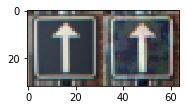

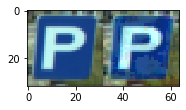

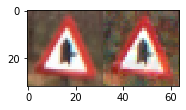

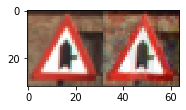

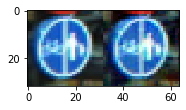

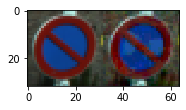

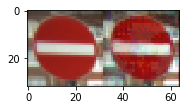

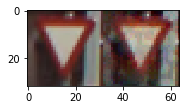

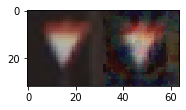

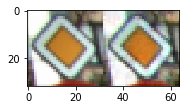

acc: 0.178 loss: 9.022


(0.17777777777777778, 9.022359997885568)

In [0]:
X_adv = perform_fgsm(sess,env, X_test, eps=.02, epochs=3)
for i in range(12,1000,100):
  plt.subplot(2, 2,2)
  plt.imshow(X_test[i])
  plt.imshow(X_adv[i])
  plot_image = np.concatenate((X_test[i], X_adv[i]), axis=1)
  plt.imshow(plot_image)
  plt.show()
evaluate(sess, env, X_adv, y_test)
